In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def load_df(mot_file: str) -> pd.DataFrame:
    df = pd.read_csv(
        mot_file,
        names=["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]
    )

    bottom_df = df[df["bb_top"] > 300].copy(deep=True)
    bottom_df["bb_top"] -= 300

    return bottom_df

mot_file = "ByteTrack/output/pNEUMA10_10-tiny.txt"

df = load_df(mot_file)

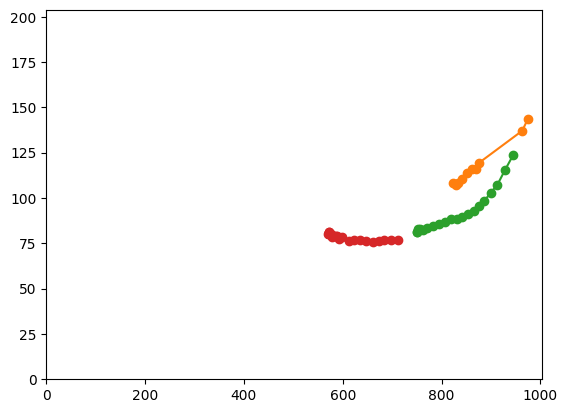

In [56]:
def get_center(df: pd.DataFrame) -> pd.DataFrame:
    """Gets the center of the car bounding box"""
    xs = df["bb_left"] + df["bb_width"] / 2
    ys = df["bb_top"] + df["bb_height"] / 2
    my_df = pd.DataFrame({
        "frame": df["frame"],
        "x": xs,
        "y": ys,
        "id": df["id"],
        "conf": df["conf"],
    })
    
    my_df['x_diff'] = my_df.groupby('id')['x'].diff()
    my_df['y_diff'] = my_df.groupby('id')['y'].diff()
    
    my_df['vx'] = my_df['x_diff'] / 1
    my_df['vy'] = my_df['y_diff'] / 1
    
    # Fill NaN values resulting from the diff calculation
    my_df.fillna(0, inplace=True)
    my_df.drop(columns=['x_diff', 'y_diff'], inplace=True)
    return my_df
    

def get_trajectory(df: pd.DataFrame, veh_id: int) -> pd.DataFrame:
    """
    Gets the trajectory for the given vehicle id, that is, the center of 
    the car at each timestep that it's present.
    """
    traj = get_center(df[df["id"] == veh_id])
    return traj

def plot_trajectory(df: pd.DataFrame, veh_id: int | list[int]) -> pd.DataFrame:
    """Plots trajectories and returns it"""
    if type(veh_id) == int:
        traj = get_trajectory(df, veh_id)
        plt.plot(traj["x"], traj["y"], '-o')
    else:
        trajs = []
        for id in veh_id:
            traj = get_trajectory(df, id)
            plt.plot(traj["x"], traj["y"], '-o')
            trajs.append(traj)
        traj = trajs
    plt.xlim(0, df["bb_left"].max())
    plt.ylim(0, df["bb_top"].max())
    return traj

def plot_frame(df, frame):
    """Plots the positions of a vehicle at a given frame"""
    new_df = df[df["frame"] == frame]
    plt.plot(new_df["x"], new_df["y"], 'o')
    plt.xlim(0, df["x"].max())
    plt.ylim(0, df["y"].max())

traj = plot_trajectory(df, list(range(5)))
_ = traj

,frame,x,y,id,conf,vx,vy
18,1,571.000269,79.999758,3,0.737287,0.000000,0.000000
48,2,571.867804,80.867736,3,0.638443,0.867535,0.867978
74,3,572.015614,81.015377,3,0.644556,0.147810,0.147641
102,4,572.045315,81.045021,3,0.653773,0.029701,0.029644
131,5,571.301610,80.301382,3,0.603356,-0.743705,-0.743639
155,6,571.769753,80.049844,3,0.537410,0.468143,-0.251538
177,7,571.933922,79.967851,3,0.580162,0.164170,-0.081993
206,8,573.358458,79.945393,3,0.746090,1.424535,-0.022458
230,9,575.283887,79.947065,3,0.830556,1.925429,0.001672
268,10,578.701476,78.574402,3,0.685462,3.417589,-1.372663


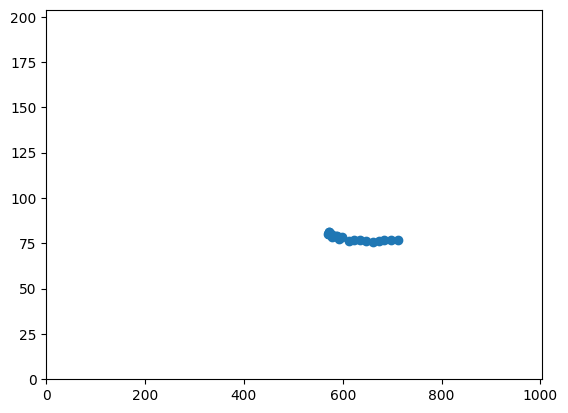

In [29]:
plot_trajectory(df, 3)

In [19]:
def near(traj: pd.DataFrame, df: pd.DataFrame):
    """ 
    Tries to calculate other trajectories which may be a continuation of 
    the fiven trajectory.
    """
    last_frame = traj["frame"].max()
    last_point = traj.iloc[[-1]]
    last_x = last_point["x"].values[0]
    last_y = last_point["y"].values[0]
    max_frames = 25
    fdf = df[
        (df["frame"] > last_frame) & (df["frame"] < last_frame + max_frames)
    ]
    res = fdf.loc[fdf.groupby("id")["frame"].idxmin()]
    print(type(res))
    res = res[((res["x"] - last_x)**2 + (res["y"] - last_y)**2) ** 0.5 < 100]
    return res

cdf = get_center(df)
# car 3 id switches to 106 and then to 185
traj = get_trajectory(df, 3)
p_ids = near(traj, cdf)

#_ = plot_trajectory(df, p_ids)
p_ids

<class 'pandas.core.frame.DataFrame'>


,frame,x,y,id,conf,vx,vy
711,26,691.301469,115.854566,17,0.810244,12.706291,-0.013948
717,26,618.572120,110.409007,18,0.897376,9.762117,-1.448666
714,26,673.152990,148.475258,21,0.907053,2.515749,1.409618
912,34,646.579819,79.044603,59,0.709645,79.784761,-3.065416
696,26,724.222481,155.005506,69,0.442636,-0.409848,0.013161
698,26,729.018662,75.036750,106,0.823372,32.402368,-2.949996
1249,46,771.399772,103.000123,218,0.526860,0.000000,0.000000
1327,49,793.799823,109.799925,230,0.609096,0.000000,0.000000


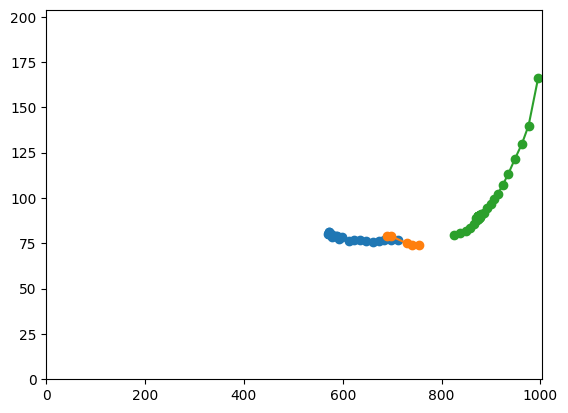

In [14]:
_ = plot_trajectory(df, [3, 106, 185])

<class 'pandas.core.frame.DataFrame'>


[     frame           x          y  id      conf         vx        vy
 18       1  571.000269  79.999758   3  0.737287   0.000000  0.000000
 48       2  571.867804  80.867736   3  0.638443   1.705270  1.301876
 74       3  572.015614  81.015377   3  0.644556   0.292927  0.221446
 102      4  572.045315  81.045021   3  0.653773   0.059844  0.044462
 131      5  571.301610  80.301382   3  0.603356  -0.788169 -0.744041
 155      6  571.769753  80.049844   3  0.537410  -0.188128 -0.614518
 177      7  571.933922  79.967851   3  0.580162  -0.022744 -0.207631
 206      8  573.358458  79.945393   3  0.746090   2.634610  0.616457
 230      9  575.283887  79.947065   3  0.830556   2.333958  0.245988
 268     10  578.701476  78.574402   3  0.685462   2.875329 -1.633933
 294     11  583.252253  78.762560   3  0.541683   3.240066 -0.577457
 319     12  586.210717  78.837473   3  0.637093   3.707767  0.442809
 347     13  589.302154  78.883660   3  0.453205   3.947568  0.534891
 380     14  592.404

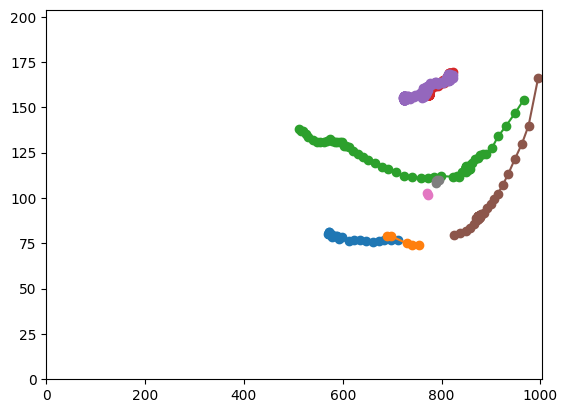

In [20]:
traj = get_trajectory(df, 106)
p_ids = near(traj, cdf)

#_ = plot_trajectory(df, p_ids)
plot_trajectory(df, [3, 106] + list(p_ids["id"].values))

In [25]:
df.groupby('id').apply(print)

     frame  id     bb_left      bb_top   bb_width  bb_height      conf  x  y  \
0        1   1  804.499558   97.000025  38.999962  22.000003  0.772708 -1 -1   
51       2   1  806.563473   94.830810  43.550862  24.603298  0.826832 -1 -1   
78       3   1  810.773212   95.565496  45.554087  25.799842  0.879568 -1 -1   
105      4   1  816.271097   96.238266  49.780161  28.362867  0.789444 -1 -1   
133      5   1  827.695596   99.907318  48.553408  27.860125  0.886145 -1 -1   
157      6   1  834.596353  100.623083  52.192140  30.330410  0.902499 -1 -1   
175      7   1  839.233172   98.234179  59.485761  35.140782  0.879561 -1 -1   
202      8   1  848.606938  102.928187  55.740116  33.232170  0.803767 -1 -1   
594     22   1  926.503505  114.184189  73.256917  45.806042  0.890399 -1 -1   
623     23   1  938.763440  119.743107  72.023264  48.056846  0.878102 -1 -1   

     z    speed_x    speed_y  
0   -1   0.000000   0.000000  
51  -1   2.063915  -2.169215  
78  -1   4.209738   0.7346

""


In [49]:
def predict(traj, n, use_last = 5):
    """Predicts the next n points of the trajectory based on the last points of the trajectory"""
    vx = traj["vx"].tail(use_last).mean()
    vy = traj["vy"].tail(use_last).mean()
    if abs(vx) < 1:
        vx = 0
    if abs(vy) < 1:
        vy = 0
    
    next_x = []
    next_y = []
    for i in range(n):
        next_x.append(traj["x"].tail(1).mean() + (i + 1) * vx)
        next_y.append(traj["y"].tail(1).mean() + (i + 1) * vy)
    return pd.DataFrame({
        "frame": [traj["frame"].tail(1).values[0] + i + 1 for i in range(n)],
        "x": next_x,
        "y": next_y,
        "id": [traj["id"].tail(1).values[0]] * n,
        "conf": [-1] * n,  
        "vx": [vx] * n,
        "vy": [vy] * n,
    })

    
traj = get_trajectory(df, 3)
pred_traj = predict(traj, 5)
print(traj)
print(pred_traj)

     frame           x          y  id      conf         vx        vy
18       1  571.000269  79.999758   3  0.737287   0.000000  0.000000
48       2  571.867804  80.867736   3  0.638443   0.867535  0.867978
74       3  572.015614  81.015377   3  0.644556   0.147810  0.147641
102      4  572.045315  81.045021   3  0.653773   0.029701  0.029644
131      5  571.301610  80.301382   3  0.603356  -0.743705 -0.743639
155      6  571.769753  80.049844   3  0.537410   0.468143 -0.251538
177      7  571.933922  79.967851   3  0.580162   0.164170 -0.081993
206      8  573.358458  79.945393   3  0.746090   1.424535 -0.022458
230      9  575.283887  79.947065   3  0.830556   1.925429  0.001672
268     10  578.701476  78.574402   3  0.685462   3.417589 -1.372663
294     11  583.252253  78.762560   3  0.541683   4.550776  0.188158
319     12  586.210717  78.837473   3  0.637093   2.958464  0.074914
347     13  589.302154  78.883660   3  0.453205   3.091437  0.046187
380     14  592.404205  77.553760 

(0.0, 203.86213622174722)

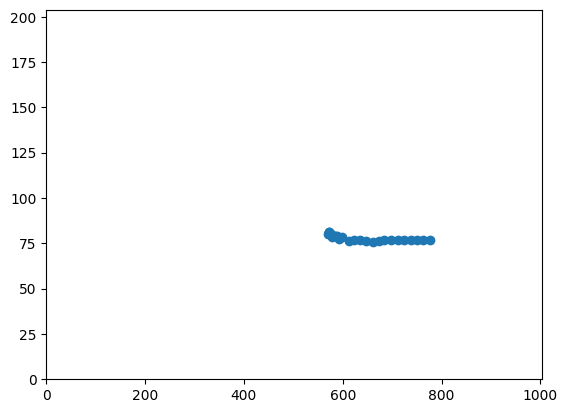

In [50]:
res = pd.concat([traj, pred_traj], ignore_index=True)
plt.plot(res["x"], res["y"], '-o')
plt.xlim(0, df["bb_left"].max())
plt.ylim(0, df["bb_top"].max())

In [52]:
near(traj, cdf)

<class 'pandas.core.frame.DataFrame'>


,frame,x,y,id,conf,vx,vy
711,26,691.301469,115.854566,17,0.810244,12.706291,-0.013948
717,26,618.572120,110.409007,18,0.897376,9.762117,-1.448666
714,26,673.152990,148.475258,21,0.907053,2.515749,1.409618
912,34,646.579819,79.044603,59,0.709645,79.784761,-3.065416
696,26,724.222481,155.005506,69,0.442636,-0.409848,0.013161
698,26,729.018662,75.036750,106,0.823372,32.402368,-2.949996
1249,46,771.399772,103.000123,218,0.526860,0.000000,0.000000
1327,49,793.799823,109.799925,230,0.609096,0.000000,0.000000


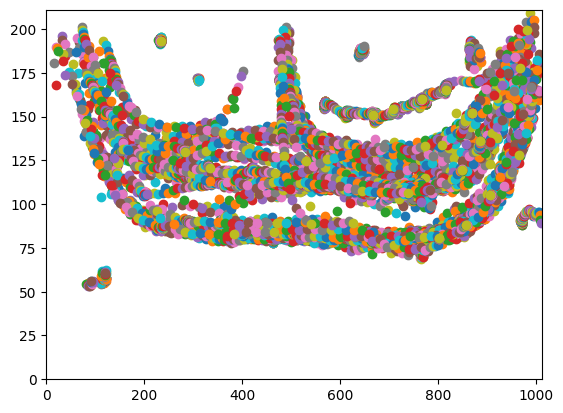

In [67]:
for i in range(1, 500):
    plot_frame(cdf, i)

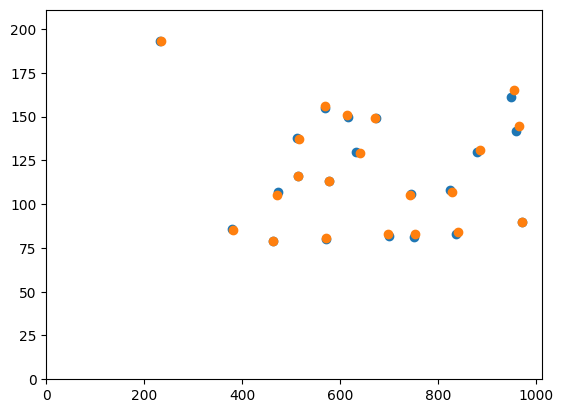

In [62]:
for i in range(1, 3):
    plot_frame(cdf, i)